In [1]:
import numpy as np
import xgboost as xgb
import preprocess
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd
import math
import numpy as np


In [2]:


class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        self.models = [self.models[loc].fit(X, y[:, loc]) for loc in range(self.num_models)]
#         self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators


        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [3]:
(train_x, train_y), (test_x, test_y) = preprocess.create_dataset()

In [4]:
all_y = np.concatenate((train_y, test_y))

In [5]:
def detrend(all_y, year_range = range(1985, 2019)):
    year_lengths = [366 if i % 4 == 0 else 365 for i in year_range]
    
    
    train_days = int(0.8*sum(year_lengths))
    test_days = sum(year_lengths) - int(0.8*sum(year_lengths))
    
    year_indices = np.cumsum(year_lengths)
    
    train_indices = year_indices[year_indices <= train_days]
    test_indices = year_indices[year_indices >= train_days]
    
    train_indices = np.append(train_indices, train_days)
    test_indices = np.insert(test_indices, 0, train_indices[-1])

    test_indices[-1] -= 28
    
    split_by_year = np.array_split(all_y[:train_days], train_indices)
    
    test_split_by_year = np.array_split(all_y[train_days:], (test_indices - train_days)[1:])[:-1]
    
    temps_by_location_by_year = np.zeros((3274, 366, 34))
    for year in range(len(split_by_year)):
        for day in range(len(split_by_year[year])):
            for loc in range(len(split_by_year[year][day])):
                temps_by_location_by_year[loc, day, year] = split_by_year[year][day, loc]
    
    test_temps_by_location_by_year = np.zeros((3274, 366, 34))
    for year in range(len(test_split_by_year)):
        for day in range(len(test_split_by_year[year])):
            for loc in range(len(test_split_by_year[year][day])):
                
                real_day = year_lengths[year] + 1 - len(test_split_by_year[year]) + day if not year else day
#                 if not year:
#                     print('original day:' + str(day) + ', realday: ' + str(real_day))
                test_temps_by_location_by_year[loc, real_day, year] = test_split_by_year[year][day, loc]
    
    means = np.zeros((3274, 366))
    stds = np.zeros((3274, 366))
    
    
    
    from scipy import stats
    for loc in range(len(temps_by_location_by_year)):
        for day in range(len(temps_by_location_by_year[loc])):
            before_replace = temps_by_location_by_year[loc, day]
            before_replace[before_replace == 0] = np.nan
            means[loc, day] = np.nanmean(before_replace)
            stds[loc, day] = np.nanstd(before_replace)
            
            temps_by_location_by_year[loc,day] = stats.zscore(before_replace, nan_policy='omit')
            
            
    for loc in range(len(test_temps_by_location_by_year)):
        for day in range(len(test_temps_by_location_by_year[loc])):
            before_replace = test_temps_by_location_by_year[loc, day]
            before_replace[before_replace == 0] = np.nan
            
            test_temps_by_location_by_year[loc,day] = (test_temps_by_location_by_year[loc,day] - means[loc, day])/stds[loc,day]
            
    flipped = np.zeros((3274, 34, 366))

    flipped_test = np.zeros((3274, 34, 366))
    
    for loc in range(len(temps_by_location_by_year)):
        for y in range(0, 34):
            flipped[loc, y] = temps_by_location_by_year[loc, :, y]
            
            
    for loc in range(len(test_temps_by_location_by_year)):
        for y in range(0, 34):
            flipped_test[loc, y] = test_temps_by_location_by_year[loc, :, y]
                 
    all_days = np.zeros((3274, len(all_y)))
    for loc in range(len(flipped)):
        testloc = np.concatenate((np.concatenate(flipped[loc]), np.concatenate(flipped_test[loc])))
        all_days[loc] = testloc[~np.isnan(testloc)]

    return all_days.T, (means, stds)

In [6]:
test_detrend, (means, stds) = detrend(all_y)

In [7]:
all_y_detrended = test_detrend
train_y_zscore = all_y_detrended[:len(train_y)]
test_y_zscore = all_y_detrended[len(train_y):]

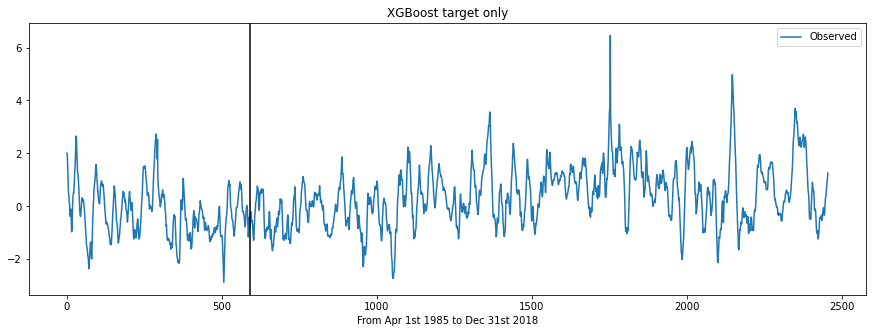

In [8]:
# print('r-sq on xgboost train:', r2_score(y_train_true, all_preds_xgboost[90:90 + len(y_train_true)]))
# print('r-sq on xgboost test:', r2_score(y_test_true,  all_preds_xgboost[90 + len(y_train_true):]))
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(test_y_zscore[:,503],label='Observed')
# plt.plot(np.concatenate((y_pred_train, y_pred_test)),label='Predicted by LSTM')
# plt.plot(all_preds_xgboost[90:],label='Predicted by XGBoost')
plt.legend()
plt.xlabel('From Apr 1st 1985 to Dec 31st 2018')
# plt.ylabel(target)
plt.title('XGBoost target only')
plt.axvline(x=590,c='black')
# print('cosine_similarity on train:', cosine_similarity(y_train_true.reshape((1,-1)), all_preds_xgboost[90:90 + len(y_train_true)].reshape((1,-1))))
# print('cosine_similarity on test:', cosine_similarity(y_test_true.reshape((1,-1)),  all_preds_xgboost[90 + len(y_train_true):].reshape((1,-1))))

In [9]:
mdl = XGBoost()

In [10]:
mdl.fit(train_x, train_y_zscore)

[15:46:55] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1598455311345/work/include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[15:46:55] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1598455311345/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:46:58] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1598455311345/work/include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_gpus=1, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, silent=True, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=

In [11]:
pred_train = mdl.predict(train_x)
pred_test = mdl.predict(test_x)

In [12]:
r_train = np.zeros(pred_train.shape[1])
r_test = np.zeros(pred_test.shape[1])

In [13]:
from sklearn.metrics import r2_score
for i in range(pred_train.shape[1]):
        r_train[i] = r2_score(train_y[:, i], pred_train[:, i])
for i in range(pred_test.shape[1]):
        r_test[i] = r2_score(test_y[:, i], pred_test[:,i])

In [14]:
import pickle
year = pickle.load( open( "/share/data/willett-group/covariates_as_numpy_"+str(2017)+'.pkl', "rb" ) )

In [15]:
test_target = pd.DataFrame(test_y).rename(columns=year['locs'])['33.75_242.25']
test_target_zscore = pd.DataFrame(test_y_zscore).rename(columns=year['locs'])['33.75_242.25']
preds_target = pd.DataFrame(pred_test).rename(columns=year['locs'])['33.75_242.25']

train_target = pd.DataFrame(train_y).rename(columns=year['locs'])['33.75_242.25']
train_target_zscore = pd.DataFrame(train_y_zscore).rename(columns=year['locs'])['33.75_242.25']
train_preds_target = pd.DataFrame(pred_train).rename(columns=year['locs'])['33.75_242.25']

In [16]:
all_preds = np.concatenate((train_preds_target.to_numpy(), preds_target.to_numpy()))

r-sq on xgboost train: 0.592893825145296
r-sq on xgboost test: -0.055196670833518535


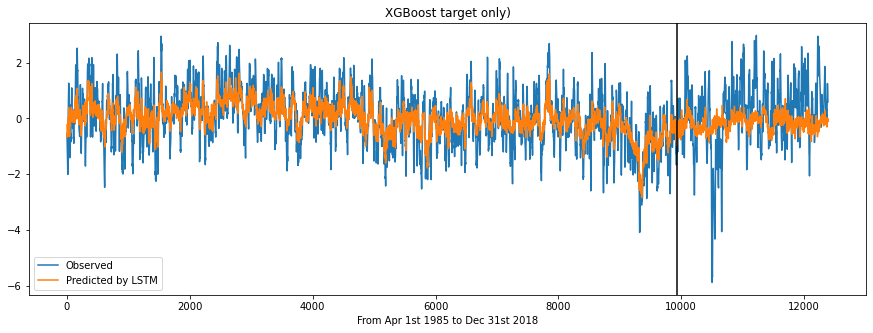

In [17]:
print('r-sq on xgboost train:', r2_score(train_target_zscore, train_preds_target))
print('r-sq on xgboost test:', r2_score(test_target_zscore, preds_target))
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(np.concatenate((train_target_zscore, test_target_zscore)),label='Observed')
plt.plot(np.concatenate((train_preds_target, preds_target)),label='Predicted by LSTM')
# plt.plot(all_preds_xgboost[90:],label='Predicted by XGBoost')
plt.legend()
plt.xlabel('From Apr 1st 1985 to Dec 31st 2018')
# plt.ylabel(target)
plt.title('XGBoost target only)')
plt.axvline(x=len(train_y),c='black')
# print('cosine_similarity on train:', compute_cosine(train_target,  train_preds_target))
# print('cosine_similarity on train:', cosine_similarity(y_train_true.reshape((1,-1)), all_preds_xgboost[90:90 + len(y_train_true)].reshape((1,-1))))
# print('cosine_similarity on test:', compute_cosine(test_target,  preds_target))

In [18]:
stds_repeated = [stds[:, :366 if i % 4 == 0 else 365] for i in range(1985, 2019)]
stds_concat = np.concatenate(stds_repeated, axis=1)

means_repeated = [means[:, :366 if i % 4 == 0 else 365] for i in range(1985, 2019)]
means_concat = np.concatenate(means_repeated, axis=1)

In [19]:
unzscored_train = train_y_zscore * stds_concat.T[:len(train_y)] + means_concat.T[:len(train_y)]
unzscored_train_preds = pred_train * stds_concat.T[:len(train_y)] + means_concat.T[:len(train_y)]

unzscored_test = test_y_zscore * stds_concat.T[len(train_y):-28] + means_concat.T[len(train_y):-28]
unzscored_test_preds = pred_test * stds_concat.T[len(train_y):-28] + means_concat.T[len(train_y):-28]

unzscored_train_preds_ones = np.ones((9934, 3274)) * stds_concat.T[:len(train_y)] + means_concat.T[:len(train_y)]
unzscored_test_preds_ones = np.ones((2456, 3274)) * stds_concat.T[len(train_y):-28] + means_concat.T[len(train_y):-28]


unzscored_train_preds_zeros = np.zeros((9934, 3274)) * stds_concat.T[:len(train_y)] + means_concat.T[:len(train_y)]
unzscored_test_preds_zeros = np.zeros((2456, 3274)) * stds_concat.T[len(train_y):-28] + means_concat.T[len(train_y):-28]



In [20]:
# r2_score(unzscored_test[:,509], unzscored_test_preds[:, 509])
r2_score(unzscored_train[:,509], unzscored_train_preds[:, 509])

0.9308735059983704

r-sq on xgboost train: 0.9308735059983704
r-sq on xgboost test: 0.803584098533973
r-sq on ones trend train: 0.6568748235010629
r-sq on ones trend test: 0.7161212337702121
r-sq on zeros trend train: 0.8284374117505314
r-sq on zeros trend test: 0.8073348845005266


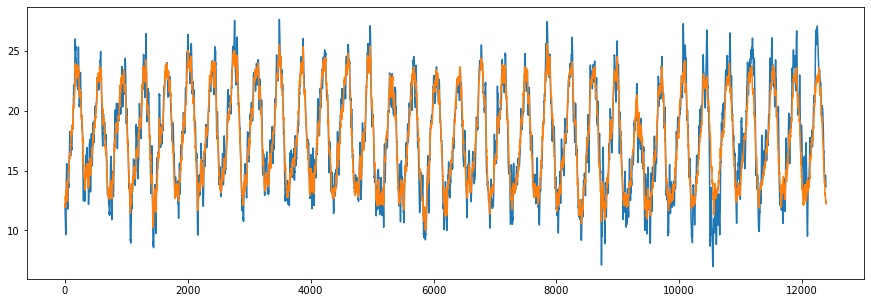

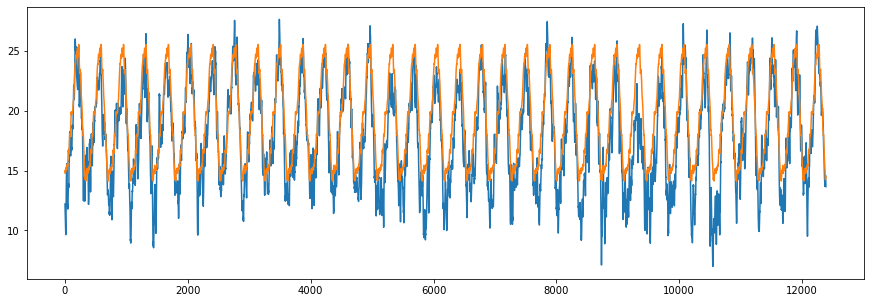

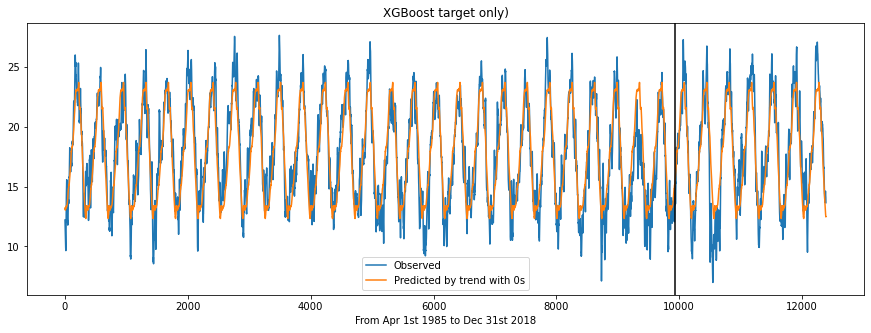

In [21]:
print('r-sq on xgboost train:', r2_score(unzscored_train[:,509], unzscored_train_preds[:, 509]))
print('r-sq on xgboost test:', r2_score(unzscored_test[:,509], unzscored_test_preds[:, 509]))

print('r-sq on ones trend train:', r2_score(unzscored_train[:,509], unzscored_train_preds_ones[:, 509]))
print('r-sq on ones trend test:', r2_score(unzscored_test[:,509], unzscored_test_preds_ones[:, 509]))


print('r-sq on zeros trend train:', r2_score(unzscored_train[:,509], unzscored_train_preds_zeros[:, 509]))
print('r-sq on zeros trend test:', r2_score(unzscored_test[:,509], unzscored_test_preds_zeros[:, 509]))
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(np.concatenate((unzscored_train[:,509], unzscored_test[:,509])),label='Observed')
plt.plot(np.concatenate((unzscored_train_preds[:,509], unzscored_test_preds[:,509])),label='Predicted by LSTM')

plt.figure(figsize=(15,5))
plt.plot(np.concatenate((unzscored_train[:,509], unzscored_test[:,509])),label='Observed')
plt.plot(np.concatenate((unzscored_train_preds_ones[:,509], unzscored_test_preds_ones[:,509])),label='Predicted by trend with 1s')

plt.figure(figsize=(15,5))
plt.plot(np.concatenate((unzscored_train[:,509], unzscored_test[:,509])),label='Observed')
plt.plot(np.concatenate((unzscored_train_preds_zeros[:,509], unzscored_test_preds_zeros[:,509])),label='Predicted by trend with 0s')

# plt.plot(all_preds_xgboost[90:],label='Predicted by XGBoost')
plt.legend()
plt.xlabel('From Apr 1st 1985 to Dec 31st 2018')
# plt.ylabel(target)
plt.title('XGBoost target only)')
plt.axvline(x=len(train_y),c='black')
# print('cosine_similarity on train:', compute_cosine(unzscored_train[:,509], unzscored_train_preds[:, 509]))
# print('cosine_similarity on train:', cosine_similarity(y_train_true.reshape((1,-1)), all_preds_xgboost[90:90 + len(y_train_true)].reshape((1,-1))))
# print('cosine_similarity on test:', compute_cosine(test_target,  preds_target))

In [22]:
print('cosine_similarity on xgboost train:', compute_cosine(unzscored_train[:,509], unzscored_train_preds[:, 509]))
print('cosine_similarity on xgboost train:', compute_cosine(unzscored_test[:,509], unzscored_test_preds[:, 509]))

print('cosine_similarity on ones vector train:', compute_cosine(unzscored_train[:,509], unzscored_train_preds_ones[:, 509]))
print('cosine_similarity on ones vector train:', compute_cosine(unzscored_test[:,509], unzscored_test_preds_ones[:, 509]))


print('cosine_similarity on zeros vector train:', compute_cosine(unzscored_train[:,509], unzscored_train_preds_zeros[:, 509]))
print('cosine_similarity on zeros vector train:', compute_cosine(unzscored_test[:,509], unzscored_test_preds_zeros[:, 509]))



NameError: name 'compute_cosine' is not defined

In [ ]:
unzscored_test[:,508], unzscored_test_preds[:, 508]